# Devanagari character recognition using CNN and pytorch

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn.functional import cross_entropy
from torch.optim import SGD, Adam

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [31]:
dataset= ImageFolder('../input/nhcd-dataset/nhcd', transform=ToTensor())

In [32]:
len(dataset)

12912

In [33]:
train_data, test_data = random_split(dataset, [10000, 2912])
val_data, test_data = random_split(test_data, [2000, 912])

In [34]:
len(train_data), len(val_data), len(test_data)

(10000, 2000, 912)

In [35]:
taregt_classes = dataset.class_to_idx
len(dataset.classes)

58

In [36]:
print(taregt_classes)

{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '43': 38, '44': 39, '45': 40, '46': 41, '47': 42, '48': 43, '49': 44, '5': 45, '50': 46, '51': 47, '52': 48, '53': 49, '54': 50, '55': 51, '56': 52, '57': 53, '6': 54, '7': 55, '8': 56, '9': 57}


In [37]:
taregt_class = dict((v,k) for k,v in taregt_classes.items())
print(taregt_class)

{0: '0', 1: '1', 2: '10', 3: '11', 4: '12', 5: '13', 6: '14', 7: '15', 8: '16', 9: '17', 10: '18', 11: '19', 12: '2', 13: '20', 14: '21', 15: '22', 16: '23', 17: '24', 18: '25', 19: '26', 20: '27', 21: '28', 22: '29', 23: '3', 24: '30', 25: '31', 26: '32', 27: '33', 28: '34', 29: '35', 30: '36', 31: '37', 32: '38', 33: '39', 34: '4', 35: '40', 36: '41', 37: '42', 38: '43', 39: '44', 40: '45', 41: '46', 42: '47', 43: '48', 44: '49', 45: '5', 46: '50', 47: '51', 48: '52', 49: '53', 50: '54', 51: '55', 52: '56', 53: '57', 54: '6', 55: '7', 56: '8', 57: '9'}


In [38]:
def show_img(img, label):
    print(taregt_class[label], img.shape)
    plt.imshow(img.permute(1,2,0))
    plt.show()

51 torch.Size([3, 28, 28])


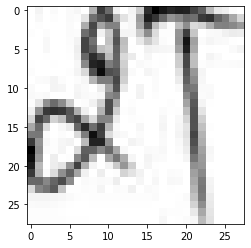

In [39]:
img, label = train_data[0]
show_img(img, label)

In [40]:
batch_size=128
lr = 0.0005

In [41]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size*2)
test_loader =  DataLoader(test_data, batch_size=batch_size*2)

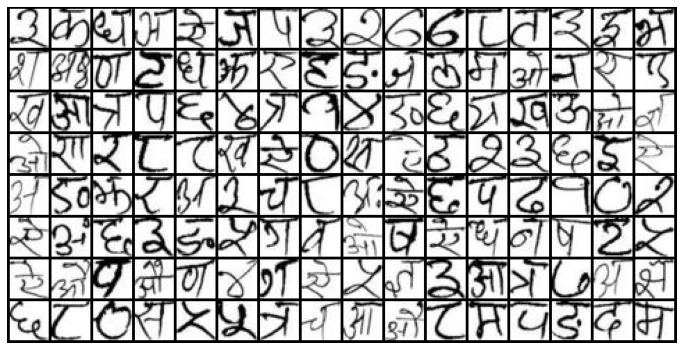

In [42]:
for imgs, yb in train_loader:
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow((make_grid(imgs, nrow=16)).permute(1,2,0))
    plt.show()
    break

In [43]:
def accuracy(preds, targets):
    maxvals, labels = torch.max(preds, dim=1)
    accuracy = torch.tensor(torch.sum(labels == targets).item()/len(labels))
    return accuracy
    
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        imgs, labels = batch
        outputs = self(imgs)
        loss = cross_entropy(outputs, labels)
        return loss

    def validation_step(self, batch):
        imgs, labels = batch
        outputs = self(imgs)
        loss = cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        
        return {'loss':loss.detach(), 'acc':acc.detach()}
    
    def validation_epoch_end(self, outputs):
        val_losses = [x['loss'] for x in outputs]
        avg_loss =torch.stack(val_losses).mean()
        
        val_accs = [x['acc'] for x in outputs]
        avg_acc =torch.stack(val_accs).mean()
        
        return {'loss': avg_loss.item(), 'acc': avg_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("epoch {} => val_loss: {}, val_acc: {}".format(epoch, result['loss'], result['acc']))
    
class DevanagariRecognize(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, stride=1, kernel_size=3, padding=1), # output: 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 X 14 X 14

            nn.Conv2d(32, 64, stride=1, kernel_size=3, padding=1), # output: 32 x 14 X 14
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 X 7 X 7

            
            nn.Flatten(), 
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 58))
    
    def forward(self, xb):
#         print(xb.shape)
        return self.network(xb)

In [44]:
model = DevanagariRecognize()
model

DevanagariRecognize(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten()
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=58, bias=True)
  )
)

In [45]:
def evaluate_test(model, val_loader):
    for batch in val_loader:
        outputs = model.validation_step(batch)
        
        print(outputs)
        break

In [46]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

In [47]:
evaluate(model, val_loader)

{'loss': 4.058141708374023, 'acc': 0.01971905119717121}

In [48]:
def fit(model, epochs, optim, lr, train_loader, val_loader):
    optim = optim(model.parameters(), lr)
    history=[]
    
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optim.step()
            optim.zero_grad()
        result = evaluate(model, val_loader)
#         print("result in fit", result)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [49]:
history = fit(model, 10, Adam, lr, train_loader,val_loader)

epoch 0 => val_loss: 2.380316734313965, val_acc: 0.3911508321762085
epoch 1 => val_loss: 1.485002040863037, val_acc: 0.5829702615737915
epoch 2 => val_loss: 1.138958215713501, val_acc: 0.6622596383094788
epoch 3 => val_loss: 0.897289514541626, val_acc: 0.7337740659713745
epoch 4 => val_loss: 0.7423515319824219, val_acc: 0.7702073454856873
epoch 5 => val_loss: 0.6539785265922546, val_acc: 0.8057016134262085
epoch 6 => val_loss: 0.622749924659729, val_acc: 0.8128004670143127
epoch 7 => val_loss: 0.5594943165779114, val_acc: 0.8365760445594788
epoch 8 => val_loss: 0.5512144565582275, val_acc: 0.8273738026618958
epoch 9 => val_loss: 0.47271570563316345, val_acc: 0.8558067679405212


In [50]:
val_loss = [x['loss'] for x in history]
val_acc = [x['acc'] for x in history]

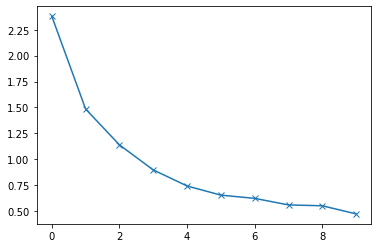

In [51]:
plt.plot(val_loss, '-x')
plt.show()

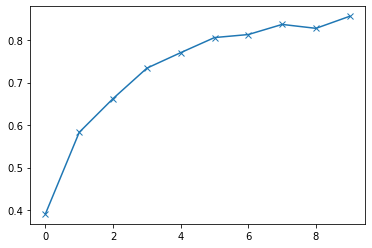

In [52]:
plt.plot(val_acc, '-x')
plt.show()

In [53]:
def predict(model, img, target):
    pred = model(img.unsqueeze(0))  
    maxval, label = torch.max(pred, dim=1)
    print("Target: {}, Prediction: {}".format(target, label.item()))
    plt.imshow(img.permute(1,2,0))
    plt.show()
    

Target: 47, Prediction: 47


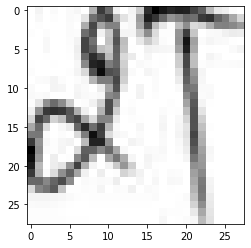

In [54]:
img, target = train_data[0]
predict(model, img, target)

Target: 14, Prediction: 14


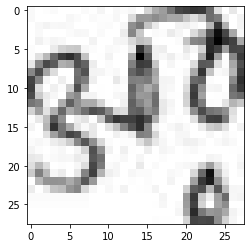

In [55]:
img, target = test_data[0]
predict(model, img, target)

Target: 20, Prediction: 20


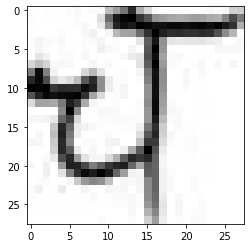

In [56]:
img, target = test_data[21]
predict(model, img, target)

In [57]:
evaluate(model, train_loader)

{'loss': 0.28660035133361816, 'acc': 0.9237539768218994}

In [58]:
evaluate(model, val_loader)

{'loss': 0.47271570563316345, 'acc': 0.8558067679405212}

In [59]:
evaluate(model, test_loader)

{'loss': 0.5357906818389893, 'acc': 0.8449435830116272}

### Performance of the model on:
1. Training data => loss:0.28 accuracy: 92.37%
2. Validation data => loss: 0.47 accuracy: 85.58%
3. Test data => loss:0.53 accuracy: 84.49%